# Reading & Understanding Data

## Importing Libraries

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import os
import random
import librosa, IPython
import librosa.display as lplt

### Loading Config

In [22]:
class Config:
    tracks = 100
    segments = 10
    seconds = 3
    rate = 22050
    data_dir = 'data'
    lib_dir = 'D:\\Musik\\Genres\\'
    genres = [e for e in os.listdir(lib_dir) if e not in ['Trash', 'Other', 'JumpUp', 
               'Hiphop','Disco', 'Rock', 'Blues', 'Classical', 'Country', 'Reggae', 'Jazz', 'Metal', 'Pop',
               'DnB', 
            #    'Crossbread', 'Neurofunk', 'Sambass', 'Jungle', 'Drumstep', 'Deep', 'Liquid', 'Minimal', 'Dancefloor',
            #    'JumpUp', 
               'Techno', 'Goa', 'PsyTrance', 
               'Hardtekk', 'Riddim', 'Breakcore', 'Dubstep']]
    sub_dir = os.path.join(data_dir, f'{tracks}x{segments}x{seconds}-{len(genres)}')
    seed = 42
config = Config()
print(config.genres)

['Shriek', 'UKay']


In [23]:
np.random.seed(config.seed)

### About the dataset

In [24]:
from src.Database import Database

db = Database(config.sub_dir)
df = db.df

In [25]:
df.head()

,filename,length,chroma_stft_var,chroma_stft_mean,rms_var,rms_mean,spectral_centroid_var,spectral_centroid_mean,spectral_bandwidth_var,spectral_bandwidth_mean,...,mfcc16_mean,mfcc17_var,mfcc17_mean,mfcc18_var,mfcc18_mean,mfcc19_var,mfcc19_mean,mfcc20_var,mfcc20_mean,label
0,03PrimateDownfall627821976Cell.0,66150.0,0.009296,0.497590,0.006605,0.274601,238001.912870,2574.155621,76711.471650,2040.774070,...,-1.334186,23.713867,-5.061430,18.567524,-3.741465,46.303562,-8.611483,24.877447,-3.954338,Shriek
1,03PrimateDownfall627821976Cell.1,66150.0,0.011243,0.501268,0.008457,0.259598,202635.808490,2508.350438,83585.551698,2060.502610,...,-0.635999,22.081547,-4.053811,19.842545,-3.295922,42.090244,-9.165074,23.949324,-4.123752,Shriek
2,03PrimateDownfall627821976Cell.2,66150.0,0.012617,0.520511,0.010584,0.243153,312105.094500,2648.990864,135553.887308,2143.874515,...,0.319971,26.146427,-3.858580,21.297817,-3.229922,41.006748,-8.822874,23.581747,-4.136311,Shriek
3,03PrimateDownfall627821976Cell.3,66150.0,0.014515,0.521294,0.010789,0.214211,344815.010903,2651.165974,159273.913974,2183.561939,...,0.444429,27.551897,-3.651434,17.837286,-3.184673,32.379326,-9.062913,14.830808,-4.248649,Shriek
4,03PrimateDownfall627821976Cell.4,66150.0,0.014213,0.514085,0.010733,0.188972,496516.524384,2758.113355,183599.431885,2234.058691,...,0.380775,26.664211,-3.621789,19.831059,-3.215118,32.757542,-9.105444,16.431623,-4.093633,Shriek


In [26]:
print("Dataset has",df.shape)
print("Count of Positive and Negative samples")
df.label.value_counts().reset_index()

Dataset has (2000, 60)
Count of Positive and Negative samples


,index,label
0,Shriek,1000
1,UKay,1000


# Data Preparation

Treat missing values.
Outlier Treatment
Define dummy variables for categorical variables.

### Missing Value Treatment

In [27]:
# find all columns with any NA values

df.drop(['length'], axis=1, inplace=True)
print("Columns with NA values are",list(df.columns[df.isnull().any()]))

Columns with NA values are []


### Encode Genre Label

In [28]:
# map labels to index
label_index = {}
index_label = {}
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'Shriek': 0, 'UKay': 1}
{0: 'Shriek', 1: 'UKay'}


In [29]:
# update labels in df to index
df.label = [label_index[l] for l in df.label]

### Split Train, Dev & Test Sets

In [30]:
# shuffle samples
df_shuffle = df.sample(frac=1, random_state=config.seed).reset_index(drop=True)

In [31]:
# remove irrelevant columns
df_shuffle.drop(['filename'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# df_X.astype(float)
df_X.info()

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=config.seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=config.seed, stratify=df_test_valid_y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 57 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   chroma_stft_var          2000 non-null   float64
 1   chroma_stft_mean         2000 non-null   float64
 2   rms_var                  2000 non-null   float64
 3   rms_mean                 2000 non-null   float64
 4   spectral_centroid_var    2000 non-null   float64
 5   spectral_centroid_mean   2000 non-null   float64
 6   spectral_bandwidth_var   2000 non-null   float64
 7   spectral_bandwidth_mean  2000 non-null   float64
 8   rolloff_var              2000 non-null   float64
 9   rolloff_mean             2000 non-null   float64
 10  zero_crossing_rate_var   2000 non-null   float64
 11  zero_crossing_rate_mean  2000 non-null   float64
 12  harmony_var              2000 non-null   float64
 13  harmony_mean             2000 non-null   float64
 14  perceptr_var            

In [32]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 1400 records out of 2000 which is 70%
Dev set has 396 records out of 2000 which is 20%
Test set has 204 records out of 2000 which is 10%


In [33]:
print(y_train.value_counts()[0]/y_train.shape[0]*100)
print(y_dev.value_counts()[0]/y_dev.shape[0]*100)
print(y_test.value_counts()[0]/y_test.shape[0]*100)

50.0
50.0
50.0


#### Scale the Features

In [34]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

# Model Building

In [35]:
import tensorflow as tf
print("TF version:-", tf.__version__)
import keras as k
tf.random.set_seed(config.seed)

TF version:- 2.8.0


In [36]:

def trainModel(model, epochs, optimizer):
    # [32, 64] - CPU
    # [128, 256] - GPU for more boost
    batch_size = 32
    
    # Stop training when a monitored metric has stopped improving.
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy'
    )
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, 
                     batch_size=batch_size, callbacks=[callback])

def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

In [37]:
model = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(len(label_index.keys()), activation='softmax'),
])
print(model.summary())
history = trainModel(model=model, epochs=100, optimizer='adam')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               29696     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)               

Max. Validation Accuracy 0.9949495196342468


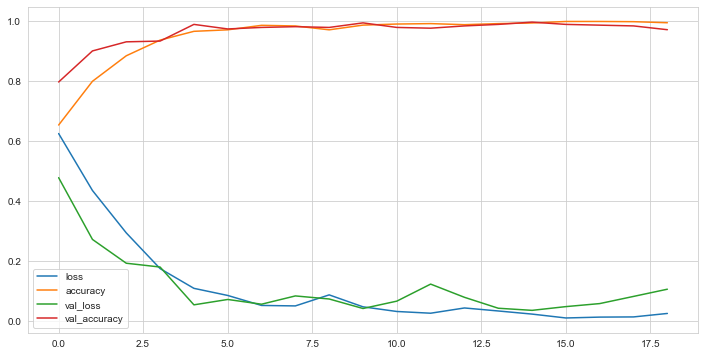

In [38]:
plotHistory(history)

In [39]:
test_loss, test_acc  = model.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is :",test_loss)
print("\nThe Best test Accuracy is :",test_acc*100)

2/2 [==============================] - 0s 5ms/step - loss: 0.1212 - accuracy: 0.9510
The test Loss is : 0.12116332352161407

The Best test Accuracy is : 95.09803652763367


In [41]:
import pickle
import joblib

model.save( os.path.join(config.sub_dir, "model.h5"))
joblib.dump(scaler , os.path.join(config.sub_dir, "scaler.pkl"))     # save to disk
with open(os.path.join(config.sub_dir, "labels.pkl"), "wb") as a_file:
    pickle.dump(index_label, a_file)